# EDA

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
from scipy.sparse import csr_matrix
from fuzzywuzzy import process
import implicit
import pickle
import os

F:\AI\Recommendation-system\.env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
## Magic function lets the bigquery run in Jupyter Notebook
%load_ext google.cloud.bigquery

### Set connection with project and dataset made on GCP

In [3]:
client = bigquery.Client()
merch_data_ref = client.dataset('merch_store', project = 'dummy24571')

In [4]:
def bq2df(sql):
    query = client.query(sql) # API request
    results = query.result()
    return results.to_dataframe()

### Raw data

In [5]:
q = ('SELECT * FROM `dummy24571.merch_store.ga_sessions_*` '
    'LIMIT 100')
complete_data = bq2df(q)
complete_data.head()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,NaN,1,1492697559,1492697559,20170420,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 7, 'minut...",4368429584712615478,None,Direct,Not Socially Engaged
1,NaN,1,1492680867,1492680867,20170420,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'South...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 2, 'minut...",4342102555691716751,None,Organic Search,Not Socially Engaged
2,NaN,1,1492690708,1492690708,20170420,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",164305643238960860,None,Direct,Not Socially Engaged
3,NaN,10,1492685011,1492685011,20170420,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Southea...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",3198064546254305578,None,Organic Search,Not Socially Engaged
4,NaN,1,1492720266,1492720266,20170420,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",038222802033793053,None,Organic Search,Not Socially Engaged


In [6]:
print("HITS :- is an array of the nested fields that are populated for any and all types of hits.\nTOTALS :- is the section contains aggregate values across the session.")

HITS :- is an array of the nested fields that are populated for any and all types of hits.
TOTALS :- is the section contains aggregate values across the session.


### Number of tables in dataset

In [8]:
merch_data = client.get_dataset(merch_data_ref)
tables = [x.table_id for x in client.list_tables(merch_data)]
len(tables)

368

The sample dataset contains jumbled Google Analytics 360 data from the Google Merchandise Store, a real ecommerce store for the period of 1-Aug-2016 to 1-Aug-2017.<br>
It includes the following kinds of information:<br>
1. Traffic source data: information about where website visitors originate. This includes data about organic traffic, paid search traffic, display traffic, etc.<br>
2. Content data: information about the behavior of users on the site. This includes the URLs of pages that visitors look at, how they interact with content, etc.<br>
3. Transactional data: information about the transactions that occur on the Google Merchandise Store website.

<br>Orignal dataset contains total of 366 tables, one table for each day. Each row of the table represents a session and columns contains the detailed information about the session. Details on table schema and columns can be found here https://support.google.com/analytics/answer/3437719?hl=en

### Extracting Data for Recommender System

In [9]:
q = """
    SELECT 
      CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId,
      hitNumber,
      time,
      page.pageTitle,
      type,
      productSKU,
      v2ProductName,
      v2ProductCategory,
      productPrice/1000000 as productPrice_USD

    FROM 
      `bigquery-public-data.google_analytics_sample.ga_sessions_20160801`, 
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS hits_product

"""

In [10]:
## Sample of data which we require 
dd = bq2df(q) 
dd.head()

,visitorId,hitNumber,time,pageTitle,type,productSKU,v2ProductName,v2ProductCategory,productPrice_USD
0,7194065619159478122-1,2,30507,Gift Cards,PAGE,GGOEGGCX056299,Gift Card - $25.00,Home/Gift Cards/,25.00
1,7194065619159478122-1,2,30507,Gift Cards,PAGE,GGOEGGCX056499,Gift Card - $50.00,Home/Gift Cards/,50.00
2,7194065619159478122-1,2,30507,Gift Cards,PAGE,GGOEGGCX056199,Gift Card- $100.00,Home/Gift Cards/,100.00
3,7194065619159478122-1,2,30507,Gift Cards,PAGE,GGOEGGCX056399,Gift Card - $250.00,Home/Gift Cards/,250.00
4,8159312408158297118-151,2,289206,Men's-T-Shirts,PAGE,GGOEGAAX0104,Google Men's 100% Cotton Short Sleeve Hero Tee...,Home/Apparel/Men's/Men's-T-Shirts/,16.99


### Loading Processed Data

In [11]:
## Loading the processed data that I stored on GCP using processd_data.py
q = """
    SELECT *
    FROM merch_store.aggregate_web_stats
    """
df = bq2df(q)
df.head()

,visitorId,itemId,session_duration
0,4063594254522767136-3,GGOEGAAX0031,7574
1,1928170213555367320-3,GGOEGAAX0031,7345
2,9654716697731503768-1,GGOEGAAX0031,21750
3,5142377269901159820-1,GGOEGAAX0031,14852
4,8139746986778805680-1,GGOEGAAX0031,22010


In [12]:
print("------- DATA SUMMARY -------\n")
print("Number of rows in processed data : {}".format(df.shape[0]))
print("Number of columns in processed data : {}\n".format(df.shape[1]))
print("Number of Customers : {}".format(df['visitorId'].nunique()))
print("Total number of products : {}\n".format(df['itemId'].nunique()))
print("Stats of the processed data : \n{}\n".format(df.describe()))
print("Number of product details viewed by the users but at the end of the session = {}".format(sum(df['session_duration'] == 1)))

------- DATA SUMMARY -------

Number of rows in processed data : 137514
Number of columns in processed data : 3

Number of Customers : 58531
Total number of products : 374

Stats of the processed data : 
       session_duration
count      1.375140e+05
mean       1.985806e+04
std        8.236952e+04
min        0.000000e+00
25%        1.512000e+03
50%        5.445000e+03
75%        1.408700e+04
max        2.562002e+06

Number of product details viewed by the users but at the end of the session = 14494


### Most Viewed Products

Most viewed article_id, as well as how often it was viewed

In [57]:
most_viewed_itemsId = df.groupby('itemId').count()
most_viewed_itemsId.sort_values('visitorId', ascending=False).head(10)
most_viewed_itemId_sorted = most_viewed_itemsId.sort_values('visitorId',ascending=False)
most_viewed_itemId_sorted.head(10)

,visitorId,session_duration
itemId,,
GGOEGAAX0104,3494,3494
GGOEGBRJ037299,3427,3427
GGOEGBRA037499,3056,3056
GGOEGAAX0358,2740,2740
GGOEGFKA022299,2616,2616
GGOEGBRJ037399,2531,2531
GGOEGFKQ020399,2395,2395
GGOEGAAX0105,2176,2176
GGOEGAAX0037,2109,2109


In [62]:
most_viewed_article = str(most_viewed_itemsId.index[0])
print('The most viewed item in the dataset : {}'.format(most_viewed_itemId_sorted.index[0]))
max_views = most_viewed_itemsId.values[0]
print('The most viewed item in the dataset was viewed how many times? {}'.format(most_viewed_itemId_sorted['visitorId'][0]))

The most viewed item in the dataset : GGOEGAAX0104
The most viewed item in the dataset was viewed how many times? 3494


### Histogram of Session Durations

Session durations could be little weird depending on how pessimistic and optimistic the customer is. We can plot the histogram of session durations in the dataset:

<AxesSubplot:ylabel='Frequency'>

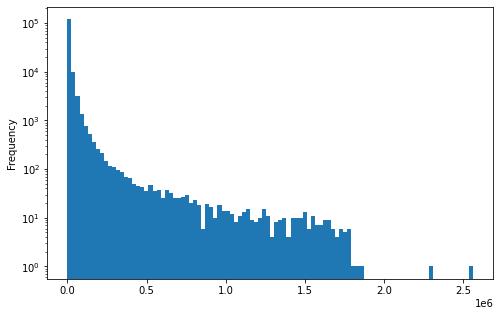

In [280]:
df['session_duration'].plot(kind= 'hist', logy=True, bins=100, figsize= [8,5])

### Normalize Session Duration

So, let’s scale and clip it the values by the median session duration (average duration will be dramatically affected by the outliers):

In [286]:
## Processed data is normalized and saved on GCP using normalized_data.py

norm_query = """
SELECT * 
FROM merch_store.recommendations_data
--WHERE 
--visitorId LIKE '6535875617262565784%';
"""
norm_df = bq2df(norm_query)
norm_df.head()

,visitorId,itemId,normalized_session_duration
0,50743654948546081-2,GGOEGAAX0031,0.120099
1,5342238128015433624-1,GGOEGAAX0031,0.122196
2,966739175376367480-2,GGOEGAAX0031,0.428319
3,8321419770612068321-1,GGOEGAAX0031,0.000883
4,4132865605127470100-1,GGOEGAAX0031,0.526131


In [291]:
## just testing if normalised data have same data as we have in processed data.
norm_df[norm_df['visitorId']== "0321971686985517255-1"]

,visitorId,itemId,normalized_session_duration
39,0321971686985517255-1,GGOEGAAX0031,0.476260
7466,0321971686985517255-1,GGOEGAAX0127,0.658146
19057,0321971686985517255-1,GGOEGAAX0350,0.000166
42678,0321971686985517255-1,GGOEGBRA037499,0.239978
44430,0321971686985517255-1,GGOEGBRB013899,0.108073
52964,0321971686985517255-1,GGOEGDHB072199,0.393067
55258,0321971686985517255-1,GGOEGDHQ015399,0.480342
112984,0321971686985517255-1,GGOEGDHQ014899,1.000000
124545,0321971686985517255-1,GGOEGAAX0326,0.000055
131148,0321971686985517255-1,GGOEGDHC017999,0.000055


### Histogram of Normalized Session Durations

Now, the session duration is scaled and in the right range:

<AxesSubplot:ylabel='Frequency'>

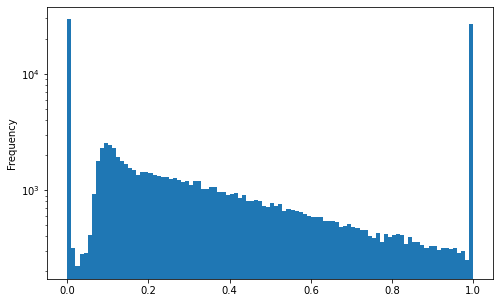

In [287]:
norm_df['normalized_session_duration'].plot(kind= 'hist', logy=True, bins=100, figsize= [8,5])

In [300]:
# dir_path = os.path.dirname(os.getcwd())
# norm_df.to_csv(os.path.join(dir_path, 'data', 'normalized_data.csv'))

### Understanding how this processed data was created

<br>
Check also for customer 0237983577378351965


In [113]:
%%bigquery
SELECT
    *
FROM
    merch_store.aggregate_web_stats
WHERE 
visitorId LIKE '6535875617262565784%';



F:\AI\Recommendation-system\.env\lib\site-packages\google\cloud\bigquery\job\query.py:1327: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type)
F:\AI\Recommendation-system\.env\lib\site-packages\google\cloud\bigquery\table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


,visitorId,itemId,session_duration
0,6535875617262565784-2,GGOEGAAX0031,13040
1,6535875617262565784-2,GGOEGAAX0651,5929
2,6535875617262565784-2,GGOEGAAX0652,10213
3,6535875617262565784-2,GGOEAKDH019899,50054
4,6535875617262565784-2,GGOEGBFC018799,2929
5,6535875617262565784-2,GGOEGBMC056599,7165
6,6535875617262565784-2,GGOEGCNB021099,18920
7,6535875617262565784-1,GGOEGDHC074099,36634
8,6535875617262565784-1,GGOEGESB015199,8597
9,6535875617262565784-1,GGOEGEVR014999,4244


In [122]:
%%bigquery
SELECT CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId, hits,productSKU, time
FROM 
    `dummy24571.merch_store.ga_sessions_2016*`,
UNNEST(hits) AS hits,
UNNEST(hits.product) AS hits_product
WHERE
    hits.hitNumber > 0 AND fullVisitorId = '6535875617262565784' AND eCommerceAction.action_type = "2"
LIMIT 50

F:\AI\Recommendation-system\.env\lib\site-packages\google\cloud\bigquery\job\query.py:1327: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type)
F:\AI\Recommendation-system\.env\lib\site-packages\google\cloud\bigquery\table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


,visitorId,hits,productSKU,time
0,6535875617262565784-2,"{'hitNumber': 4, 'time': 242108, 'hour': 16, '...",GGOEAKDH019899,242108
1,6535875617262565784-2,"{'hitNumber': 7, 'time': 311126, 'hour': 16, '...",GGOEGOXQ016399,311126
2,6535875617262565784-2,"{'hitNumber': 15, 'time': 380039, 'hour': 16, ...",GGOEGCNB021099,380039
3,6535875617262565784-2,"{'hitNumber': 22, 'time': 576384, 'hour': 16, ...",GGOEGAAX0651,576384
4,6535875617262565784-2,"{'hitNumber': 24, 'time': 582319, 'hour': 16, ...",GGOEGAAX0652,582319
5,6535875617262565784-2,"{'hitNumber': 29, 'time': 823540, 'hour': 16, ...",GGOEGBFC018799,823540
6,6535875617262565784-2,"{'hitNumber': 38, 'time': 932716, 'hour': 16, ...",GGOEGAAX0031,932716
7,6535875617262565784-2,"{'hitNumber': 41, 'time': 973404, 'hour': 16, ...",GGOEGCNB021099,973404
8,6535875617262565784-2,"{'hitNumber': 49, 'time': 1199208, 'hour': 16,...",GGOEGBMC056599,1199208
9,6535875617262565784-1,"{'hitNumber': 5, 'time': 88142, 'hour': 10, 'm...",GGOEGDHC074099,88142


In [131]:
%%bigquery
SELECT 
    CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId,
    date, visitStartTime,
    hits.hitNumber, totals.hits AS totals_hits,productSKU, hits.time, hits.hour
FROM 
    `dummy24571.merch_store.ga_sessions_2016*`,
UNNEST(hits) AS hits,
UNNEST(hits.product) AS hits_product
WHERE
    hits.hitNumber > 0 AND fullVisitorId = '6535875617262565784' AND visitNumber = 2 AND hitNumber = 5
LIMIT 95

F:\AI\Recommendation-system\.env\lib\site-packages\google\cloud\bigquery\job\query.py:1327: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type)
F:\AI\Recommendation-system\.env\lib\site-packages\google\cloud\bigquery\table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


,visitorId,date,visitStartTime,hitNumber,totals_hits,productSKU,time,hour
0,6535875617262565784-2,20160915,1473980323,5,52,GGOEGOXQ016399,292162,16
1,6535875617262565784-2,20160915,1473980323,5,52,GGOEGODR017799,292162,16
2,6535875617262565784-2,20160915,1473980323,5,52,GGOEGOFH020299,292162,16


In [134]:
# For customer 6535875617262565784-2, product = GGOEAKDH019899, time_duration is calculated by 
# taking the difference of click time of this product and the next product click time.
# this procuct hitNumber = 4 and time is 242108, next product click time is 292162.
hit4_time = 242108
hit5_time = 292162
sess_duration = hit5_time - hit4_time
sess_duration

50054